In [1]:
from data import*

Using TensorFlow backend.


In [2]:
def generate_synth_motion_data(train_dataset_name_list, save_dataset_name=None, resample_dt=.1, Ncoils=2, **params):
    train_dataset = defaultdict(list)
    for train_dataset_name in train_dataset_name_list:
        sys = SYSTEM(train_dataset_name)
        dataset = sys.get_dataset(resample_dt=resample_dt, as_dict=True)
        for key,value in dataset.items(): train_dataset[key].extend(value)
    # Convert all inputs from list of list into into dixed length matrix 
    Nt = min( [len(time) for time in train_dataset['time']])    
    for key, value in train_dataset.items(): train_dataset.update({ key: np.array([v[:Nt] for v in train_dataset[key]]) }) 

    norm = train_dataset['norm']
    centers = np.array([ value for key,value in train_dataset.items() if key[:6] == 'center'])
    center = np.nanmean(centers, axis=0)
    d_centers = np.array([center_n-center for center_n in centers])
    d = np.nanmedian(np.linalg.norm(d_centers, axis=-1)) 
    # phi = np.mod(np.arctan2(d_centers[0,:,:,1], d_centers[0,:,:,0]), 2*pi) 
    phi = np.arctan2(d_centers[0,:,:,1], d_centers[0,:,:,0])

    synthesizer = SYNTHESIZER()
    norm_synth = synthesizer.generate( norm, cond=True, **params)
    phi_synth = synthesizer.generate( phi, **params)
    phi_synth = phi_synth[:,:,0]
    center_synth = synthesizer.generate( center, **params)

    centers_synth = np.zeros((Ncoils, center_synth.shape[0], center_synth.shape[1], center_synth.shape[2]))
    for i in range(centers_synth.shape[1]):
        for j in range(centers_synth.shape[2]):
            R_rot = get_rotationMatrix( 
                np.arctan(norm_synth[i,j,1]/norm_synth[i,j,2] ), 
                -np.arctan(norm_synth[i,j,0]/np.sqrt(norm_synth[i,j,1]**2+norm_synth[i,j,2]**2)), 0).transpose()
            for n in range(centers_synth.shape[0]): 
                phi_n = phi_synth[i,j] + n * 2*pi/Ncoils
                c_n = np.array([ d*np.cos(phi_n), d*np.sin(phi_n), 0 ])             
                centers_synth[n,i,j,:] = np.matmul(R_rot, c_n.reshape(3,1)).reshape(1,3)[0] + center_synth[i,j]

    if save_dataset_name is not None:
        folder_path = get_dataset_folder_path(save_dataset_name) 
        create_folder(folder_path + '/tst.csv')
        time = list(np.arange(Nt)*resample_dt)
        
        for m in range(norm_synth.shape[0]):
            file_path = folder_path + '/record_' + "{0:0=4d}".format(m) + '.csv'
            data =  pd.DataFrame({ 'time': time, 'norm': list(norm_synth[m]) }) 
            for n in range(Ncoils): data['center_'+str(n+1)] = list(centers_synth[n, m]) 
            data.to_csv(file_path, index=None) 
    else:
        return dict(
            time = list(np.arange(Nt)*resample_dt),
            norm = norm_synth,
            centers = centers_synth
        )

In [37]:
synth_data = generate_synth_motion_data( 
    ['arduino'], save_dataset_name='synth', resample_dt=.1, Ncoils=2, N=2000, window_length=15, epochs=500, hiddendim=300, latentdim=300)

In [33]:
c = np.nanmean(synth_data['centers'], axis=0)
n = synth_data['norm']
c1 = synth_data['centers'][0]
c2 = synth_data['centers'][1]

In [34]:
np.shape(n)

(10, 338, 3)

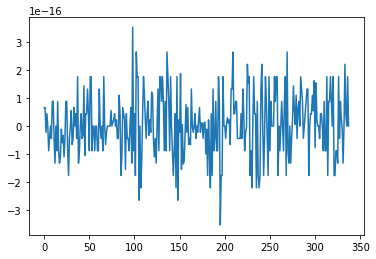

In [36]:
dc = c1-c2
d = np.sum(np.multiply(dc, n), axis=2)/np.linalg.norm(dc, axis=2)
plt.plot(d[0])

In [ ]:
train_dataset_name_list = ['arduino']
resample_dt=.1
Ncoils=4
params = dict(N=10, window_length=15, epochs=500, hiddendim=300, latentdim=300)


In [3]:
# 

In [17]:
# dataset = load_dataset('synth_01')
# for n, data in enumerate(dataset):
#     file_path = 'C:/Users/mixil/Desktop/MIHAR_Hardware/experiments/dataset/synth_01/data_/record_' + "{0:0=4d}".format(n) + '.csv'
#     data = data.loc[:, ['time','norm','center_1','center_2','synth_vind_1', 'synth_vind_2']]
#     data.to_csv(file_path, index=None) 